# UDL Mini-Project

## Import libraries & set device

In [1]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import copy
import torch.nn.functional as F
import math
import json

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

### Permuted MNIST

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
num_tasks = 8
perms = [torch.from_numpy(np.random.RandomState(12345 + t).permutation(28*28)).long()
         for t in range(num_tasks)]

# Generate permutation
rng_permute = np.random.RandomState(92916)
idx_permute = torch.from_numpy(rng_permute.permutation(28*28)).long()

def permute_image(image, permutation):
  x = image.view(-1)[permutation]
  return x.view(28, 28).unsqueeze(0)

def get_permute_transform(permutation):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: permute_image(x, permutation)),
        transforms.Normalize((0.1307,), (0.3081,)) # Normalize using mean and std of MNIST
    ])

task_data_loaders = []
task_test_loaders = []

for perm in perms:
    transform = get_permute_transform(perm)
    task_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    task_loader = DataLoader(task_dataset, batch_size=256, num_workers=4, shuffle=True)
    task_data_loaders.append(task_loader)

    task_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    task_test_loader = DataLoader(task_test_dataset, batch_size=1000, num_workers=4, shuffle=False)
    task_test_loaders.append(task_test_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.14MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


## Define Models

### Simple NN

In [ ]:
class VanillaNN(nn.Module):
    def __init__(self):
        super(VanillaNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### VCL

In [15]:
class VariationalLinear(nn.Module):
    def __init__(self, in_features, out_features, init_weight_mu=None,
                 init_bias_mu=None, init_weight_var=None, init_bias_var=None):
        super(VariationalLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        if init_weight_mu is not None:
            self.weight_mu = nn.Parameter(init_weight_mu.clone())
        else:
            self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))

        if init_bias_mu is not None:
            self.bias_mu = nn.Parameter(init_bias_mu.clone())
        else:
            self.bias_mu = nn.Parameter(torch.Tensor(out_features))

        if init_weight_var is not None:
            self.weight_logvar = nn.Parameter(init_weight_var.clone())
        else:
            self.weight_logvar = nn.Parameter(torch.Tensor(out_features, in_features))

        if init_bias_var is not None:
          self.bias_logvar = nn.Parameter(init_bias_var.clone())
        else:
          self.bias_logvar = nn.Parameter(torch.Tensor(out_features))

        self.reset_parameters(init_weight_mu, init_bias_mu, init_weight_var, init_bias_var)

    def reset_parameters(self, init_weight_mu=None, init_bias_mu=None,
                         init_weight_var=None, init_bias_var=None):
        # If initial means are not provided, use Kaiming initialization.
        if init_weight_mu is None:
            nn.init.kaiming_uniform_(self.weight_mu)

        if init_weight_var is None:
            self.weight_logvar.data.fill_(math.log(1e-6))

        # If initial biases are not provided, use a similar approach
        # to that of the paper.
        if init_bias_mu is None:
            nn.init.trunc_normal_(self.bias_mu, std=0.1)

        if init_bias_var is None:
            self.bias_logvar.data.fill_(math.log(1e-6))

    def forward(self, input):
        if self.training:
            epsilon_w = torch.randn_like(self.weight_mu)
            weight = self.weight_mu + torch.exp(0.5 * self.weight_logvar) * epsilon_w
            epsilon_b = torch.randn_like(self.bias_mu)
            bias = self.bias_mu + torch.exp(0.5 * self.bias_logvar) * epsilon_b
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)

In [ ]:
class VariationalMNISTNet(nn.Module):
    def __init__(self, init_fc1_weight=None, init_fc1_bias=None,
                       init_fc2_weight=None, init_fc2_bias=None,
                       init_fc3_weight=None, init_fc3_bias=None,
                       init_fc1_weight_var=None, init_fc1_bias_var=None,
                       init_fc2_weight_var=None, init_fc2_bias_var=None,
                       init_fc3_weight_var=None, init_fc3_bias_var=None,
                         ):
        super(VariationalMNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = VariationalLinear(28*28, 100, init_weight_mu=init_fc1_weight, init_bias_mu=init_fc1_bias,
                                                 init_weight_var=init_fc1_weight_var, init_bias_var=init_fc1_bias_var)
        self.relu = nn.ReLU()

        self.fc2 = VariationalLinear(100, 100, init_weight_mu=init_fc2_weight, init_bias_mu=init_fc2_bias,
                                                 init_weight_var=init_fc2_weight_var, init_bias_var=init_fc2_bias_var)
        self.fc3 = VariationalLinear(100, 10, init_weight_mu=init_fc3_weight, init_bias_mu=init_fc3_bias,
                                                 init_weight_var=init_fc3_weight_var, init_bias_var=init_fc3_bias_var)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train Loop

In [4]:
global_params = {
    "lr": 1e-3,  # learning rate
    "epochs": 3,  # number of total training epochs
    "coreset_sizes": [0, 250, 2500, 5000], # sizes of coresets to train on
    "lambda": [1, 10, 100], # different lambdas for EWC to train on
    "alpha": [0.5, 1, 2] # different alpha for UA-VCL to train on
}

### Get Initialization Weights

In the original paper, they first train a simple MLE model on the very first task and use those weights and biases to initialize the VCL model.

In [ ]:
def train_vanilla(model, train_loader, epochs=100, regression=False):
    if regression:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=global_params['lr'])

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data = data.to(device)

            if regression:
                target = target.to(device).float()
            else:
                target = target.to(device)

            optimizer.zero_grad()
            output = model(data)

            if regression:
                loss = criterion(output, target)
            else:
                loss = criterion(output, target)

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}")
    return model

In [ ]:
vanilla_model = VanillaNN().to(device)

#### Classification

In [ ]:
vanilla_model = train_vanilla(vanilla_model, task_data_loaders[0], epochs=3)

# Extract weights from vanilla_model
vanilla_state = vanilla_model.state_dict()

Epoch 1/3
Epoch 2/3
Epoch 3/3


#### Regression

In [ ]:
vanilla_model_reg = train_vanilla(vanilla_model, task_data_loaders[0], epochs=3)

# Extract weights from vanilla_model
vanilla_state_reg = vanilla_model_reg.state_dict()

Epoch 1/3
Epoch 2/3
Epoch 3/3


### Define Loss

In [5]:
def kl_divergence_layer(current_layer, prior_layer):
    # For weight parameters
    w_mu = current_layer.weight_mu
    w_logvar = current_layer.weight_logvar
    p_w_mu = prior_layer.weight_mu
    p_w_logvar = prior_layer.weight_logvar

    kl_weight = torch.sum(0.5 * (
        p_w_logvar - w_logvar +
        (torch.exp(w_logvar) + (w_mu - p_w_mu)**2) / torch.exp(p_w_logvar) - 1
    ))

    # For bias parameters
    b_mu = current_layer.bias_mu
    b_logvar = current_layer.bias_logvar
    p_b_mu = prior_layer.bias_mu
    p_b_logvar = prior_layer.bias_logvar

    kl_bias = torch.sum(0.5 * (
        p_b_logvar - b_logvar +
        (torch.exp(b_logvar) + (b_mu - p_b_mu)**2) / torch.exp(p_b_logvar) - 1
    ))

    return kl_weight + kl_bias

In [ ]:
def gaussian_nll_loss(output, target, sigma=1.0):
    # See report for formula derivation.

    mse = F.mse_loss(output, target, reduction='sum')
    return 0.5 * mse / (sigma ** 2)

In [ ]:
def vcl_loss(model, prev_model, x, y, regression=False, ua=False, alpha=1.0):
    outputs = model(x)

    beta = torch.tensor(1.0, device=device)
    if regression:
      # Convert targets to one-hot if needed:
      y_onehot = F.one_hot(y, num_classes=10).float()
      # Negative log-likelihood loss if likelihood is Gaussian:
      likelihood_loss = gaussian_nll_loss(outputs, y_onehot, 1)
    else:
      # Likelihood term (this approximates -E_{θ ~ q(θ)}[log p(y|x, θ)]).
      likelihood_loss = F.cross_entropy(outputs, y)

      # Compute the average entropy of the current batch's predictions.
      if ua:
        probs = F.softmax(outputs, dim=1)
        # Add small constant to avoid log(0).
        entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1)
        H_bar = torch.mean(entropy)
        beta = torch.exp(-alpha * H_bar).detach()
        # if random.random() < 0.01:
        #     print(f"H_bar: {H_bar}, beta: {beta}")

    # KL divergence term: sum KL divergences over all variational layers.
    kl_loss = 0.0
    if prev_model is None:
        # Compare to a fixed prior N(0,I): prior mu=0 and logvar=0.
        def kl_to_prior(param_mu, param_logvar):
            # KL(N(mu, sigma^2) || N(0,1)) = -log(sigma) + (sigma^2 + mu^2)/2 - 0.5
            sigma2 = torch.exp(param_logvar)
            return torch.sum(-0.5 * param_logvar + (sigma2 + param_mu**2) / 2 - 0.5)

        for layer in [model.fc1, model.fc2, model.fc3]:
          kl_loss += kl_to_prior(layer.weight_mu, layer.weight_logvar)
          kl_loss += kl_to_prior(layer.bias_mu, layer.bias_logvar)
    else:
        # Compare current and previous variational params.
        kl_loss += kl_divergence_layer(model.fc1, prev_model.fc1)
        kl_loss += kl_divergence_layer(model.fc2, prev_model.fc2)
        kl_loss += kl_divergence_layer(model.fc3, prev_model.fc3)

    batch_size = y.shape[0]

    # Scale the KL loss to get a per-parameter per-sample cost.
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_loss = likelihood_loss + beta * (kl_loss / (num_params * batch_size))
    return total_loss, beta

In [ ]:
def train_vcl(model, prev_model, train_loader, key, regression=False, kl_ua=False, alpha=1.0):
    global classification_results

    dataset_size = len(train_loader.dataset)
    optimizer = optim.Adam(model.parameters(), lr=global_params["lr"])
    for epoch in range(global_params['epochs']):
        model.train()
        total_loss = 0.0

        beta_list = []
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss, beta = vcl_loss(model, prev_model, data, target, regression, kl_ua, alpha)
            beta_list.append(beta.cpu())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        mean_beta = float(np.mean(beta_list))
        classification_results[key]["mean_beta"].append(mean_beta)
        print(f"Epoch {epoch+1}/{global_params['epochs']}: Loss = {total_loss/len(train_loader):.4f}")
    return model

### Train & Evaluate

#### Train VCL

##### Data Collection Functions

In [ ]:
classification_results = {}

In [ ]:
regression_results = {}

##### Coreset Helper Functions

In [ ]:
def subset_to_numpy(subset):
    # Get entire subset as one batch, as to then extract entire subset
    # as numpy arrays.
    loader = DataLoader(subset, batch_size=len(subset), shuffle=False)
    for x, y in loader:
        return x.numpy(), y.numpy()

def merge_coresets(x_coresets, y_coresets):
    # Stack coresets along the first dimension.
    merged_x = np.vstack(x_coresets)
    merged_y = np.concatenate(y_coresets)
    return merged_x, merged_y

###### Random Selection

In [ ]:
def pick_random_coreset(train_loader, coreset_size):
    dataset = train_loader.dataset
    total_indices = list(range(len(dataset)))

    # Randomly choose indices for the coreset without replacement.
    coreset_indices = random.sample(total_indices, coreset_size)

    # The remaining indices are those not in the coreset.
    remaining_indices = list(set(total_indices) - set(coreset_indices))

    # Create Subset objects for the coreset and for the remaining training data.
    coreset_subset = torch.utils.data.Subset(dataset, coreset_indices)
    remaining_subset = torch.utils.data.Subset(dataset, remaining_indices)

    # Create a new DataLoader for the remaining training data.
    new_loader = DataLoader(remaining_subset, batch_size=train_loader.batch_size, shuffle=True)

    return new_loader, coreset_subset

###### Uncertainty Based

In [ ]:
def compute_uncertainty(model, dataset):
    model.eval()
    uncertainties = []
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    # Use a counter to keep track of sample indices.
    idx_counter = 0
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            outputs = model(data)
            probs = F.softmax(outputs, dim=1)
            # Compute per-sample entropy (add 1e-9 to avoid log(0)).
            batch_entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1)
            for h in batch_entropy.cpu().numpy():
                # Create (index, entropy) pairs.
                uncertainties.append((idx_counter, h))
                idx_counter += 1
    return uncertainties

def uncertainty_based_coreset_selection(model, dataset, coreset_size):
    uncertainties = compute_uncertainty(model, dataset)

    # Extract just the entropy values.
    entropy_values = [entropy for _, entropy in uncertainties]

    # Compute the median entropy.
    median_entropy = np.median(entropy_values)

    # Sort samples based on the absolute difference from the median.
    uncertainties.sort(key=lambda x: abs(x[1] - median_entropy))

    # Get coreset_size samples around the median.
    coreset_indices = [idx for idx, _ in uncertainties[:coreset_size]]

    # Create two Subset objects: one for the coreset and one for the remaining samples.
    all_indices = list(range(len(dataset)))
    remaining_indices = list(set(all_indices) - set(coreset_indices))
    coreset_subset = torch.utils.data.Subset(dataset, coreset_indices)
    remaining_subset = torch.utils.data.Subset(dataset, remaining_indices)
    return remaining_subset, coreset_subset

##### Evaluation Functions

In [ ]:
def bayesian_predict(model, x, K=50):
    model.train()
    all_probs = []
    with torch.no_grad():
        for _ in range(K):
            logits = model(x)
            all_probs.append(F.softmax(logits, dim=1))
    all_probs = torch.stack(all_probs, dim=0)
    mean_probs = all_probs.mean(0)
    preds      = mean_probs.argmax(1)
    model.eval()
    return preds

def evaluate_on_seen_tasks(eval_model, task_index, key, sample=False):
    global classification_results

    print(f"\nStarting evaluation on tasks 1 to {task_index+1}:")
    total_correct = 0
    total_samples = 0
    for j in range(task_index+1):
        eval_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in task_test_loaders[j]:
                data, target = data.to(device), target.to(device)
                if sample:
                  predicted = bayesian_predict(eval_model, data, K=30)
                else:
                  output = eval_model(data)
                  _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        task_acc = 100 * correct / total
        print(f"Test Accuracy for Task {j+1}: {task_acc:.2f}%")

        task_key = f"task_{j+1}"

        if task_key not in classification_results[key]:
          classification_results[key][task_key] = [task_acc]
        else:
          classification_results[key][task_key].append(task_acc)

        total_correct += correct
        total_samples += total
    avg_acc = 100 * total_correct / total_samples
    classification_results[key]["accuracies"].append(avg_acc)
    print(f"Average Test Accuracy after Task {task_index+1}: {avg_acc:.2f}%\n")

def evaluate_on_seen_tasks_regression(eval_model, task_index, key):
    global regression_results

    eval_model.eval()
    total_mse = 0.0
    total_samples = 0

    print(f"\nStarting evaluation on tasks 1 to {task_index+1}:")
    for j in range(task_index+1):
        task_mse = 0.0
        total = 0
        with torch.no_grad():
            for data, target in task_test_loaders[j]:
                data, target = data.to(device), target.to(device)
                output = eval_model(data)
                target_onehot = F.one_hot(target, num_classes=10).float()
                batch_mse = F.mse_loss(output, target_onehot, reduction='sum')
                task_mse += batch_mse.item()
                total += data.size(0)
        task_rmse = np.sqrt(task_mse / (total * 10))
        print(f"RMSE for Task {j+1}: {task_rmse:.2f}")
        total_mse += task_mse
        total_samples += total

    # Divide by total samples and number of output dimensions to get average
    # MSE per element.
    rmse = np.sqrt(total_mse / (total_samples * 10))
    regression_results[key]["RMSE"].append(rmse)
    print(f"Average Test RMSE after Task {task_index+1}: {rmse:.2f}\n")

##### Train Model

In [ ]:
def setup_results_dict(params, regression=False, mh=False):
    global regression_results
    global classification_results
    global classification_results_mh

    model_name = params["model_name"]
    coreset_size = params.get("coreset_size", None)
    lambda_val = params.get("lambda", None)
    alpha = params.get("alpha", None)

    key = f"{model_name}_coreset_{coreset_size}_lambda_{lambda_val}_alpha_{alpha}"

    if regression:
        regression_results[key] = {"RMSE": [], "mean_beta": []}
    else:
        if not mh:
          classification_results[key] = {"accuracies": [], "mean_beta": []}
        else:
          classification_results_mh[key] = {}


    return key

###### VCL

In [ ]:
def train_continual_vcl(model, task_train_loaders, coreset_size=0, regression=False, kl_ua=False, alpha=1.0):
    x_coresets = []
    y_coresets = []

    params = {
        "model_name": "VCL",
        "coreset_size": coreset_size,
        "lambda": -1,
        "alpha": alpha
    }

    if kl_ua: params["model_name"] += "-WKL"

    key = setup_results_dict(params, regression)

    # Loop over tasks sequentially.
    for t, train_loader in enumerate(task_train_loaders):
        if coreset_size > 0:
            new_train_loader, coreset_subset = pick_random_coreset(train_loader, coreset_size)
            # Append the selected coreset for task t to the memory.
            x_core, y_core = subset_to_numpy(coreset_subset)
            x_coresets.append(x_core)
            y_coresets.append(y_core)
            # Use new_train_loader for training on this task.
            effective_train_loader = new_train_loader
        else:
            effective_train_loader = train_loader

        print(f"Starting training on task {t+1}:")
        prev_model = copy.deepcopy(model)
        model = train_vcl(model, prev_model, effective_train_loader, key, regression, kl_ua, alpha)

        if coreset_size > 0 and len(x_coresets) > 0:
            print("Training final model on merged coreset for evaluation...")
            merged_x, merged_y = merge_coresets(x_coresets, y_coresets)
            tensor_x = torch.tensor(merged_x, dtype=torch.float32)
            tensor_y = torch.tensor(merged_y, dtype=torch.long)
            # Create a dataset and loader for the merged coreset.
            coreset_dataset = torch.utils.data.TensorDataset(tensor_x.view(-1, 1, 28, 28), tensor_y)
            coreset_loader = DataLoader(coreset_dataset, batch_size=256, shuffle=True)
            # Create a new final model initialized with the current model’s parameters.
            final_model = VariationalMNISTNet(
                model.state_dict()['fc1.weight_mu'], model.state_dict()['fc1.bias_mu'],
                model.state_dict()['fc2.weight_mu'], model.state_dict()['fc2.bias_mu'],
                model.state_dict()['fc3.weight_mu'], model.state_dict()['fc3.bias_mu'],
                model.state_dict()['fc1.weight_logvar'], model.state_dict()['fc1.bias_logvar'],
                model.state_dict()['fc2.weight_logvar'], model.state_dict()['fc2.bias_logvar'],
                model.state_dict()['fc3.weight_logvar'], model.state_dict()['fc3.bias_logvar'],
            ).to(device)
            # Compute final variational distribution used for prediction.
            final_model = train_vcl(final_model, model, coreset_loader, key, regression, kl_ua, alpha)
            eval_model = final_model
        else:
            eval_model = model

        if regression:
          evaluate_on_seen_tasks_regression(eval_model, t, key)
        else:
          evaluate_on_seen_tasks(eval_model, t, key, True)

    return model

###### UA-VCL

In [ ]:
def train_continual_ua_vcl(model, task_train_loaders, coreset_size=0, kl_ua=False, alpha=1.0):
    x_coresets = []
    y_coresets = []

    params = {
        "model_name": "UA-VCL",
        "coreset_size": coreset_size,
        "lambda": -1,
        "alpha": alpha
    }

    if kl_ua: params["model_name"] += "-WKL"

    key = setup_results_dict(params)

    for t, train_loader in enumerate(task_train_loaders):
        prev_model = copy.deepcopy(model)
        model = train_vcl(model, prev_model, train_loader, key, False, kl_ua, alpha)

        if coreset_size > 0:
            remaining_subset, coreset_subset = uncertainty_based_coreset_selection(model, train_loader.dataset, coreset_size)
            x_core, y_core = subset_to_numpy(coreset_subset)
            x_coresets.append(x_core)
            y_coresets.append(y_core)

            print("Training final model on merged coreset for evaluation...")
            merged_x, merged_y = merge_coresets(x_coresets, y_coresets)
            tensor_x = torch.tensor(merged_x, dtype=torch.float32)
            tensor_y = torch.tensor(merged_y, dtype=torch.long)
            # Create a dataset and loader for the merged coreset.
            coreset_dataset = torch.utils.data.TensorDataset(tensor_x.view(-1, 1, 28, 28), tensor_y)
            coreset_loader = DataLoader(coreset_dataset, batch_size=256, shuffle=True)
            # Create a new final model initialized with the current model’s parameters.
            final_model = VariationalMNISTNet(
                model.state_dict()['fc1.weight_mu'], model.state_dict()['fc1.bias_mu'],
                model.state_dict()['fc2.weight_mu'], model.state_dict()['fc2.bias_mu'],
                model.state_dict()['fc3.weight_mu'], model.state_dict()['fc3.bias_mu'],
                model.state_dict()['fc1.weight_logvar'], model.state_dict()['fc1.bias_logvar'],
                model.state_dict()['fc2.weight_logvar'], model.state_dict()['fc2.bias_logvar'],
                model.state_dict()['fc3.weight_logvar'], model.state_dict()['fc3.bias_logvar'],
            ).to(device)
            final_model = train_vcl(final_model, model, coreset_loader, key, False, kl_ua, alpha)
            eval_model = final_model
        else:
            eval_model = model

        # Evaluate on all tasks seen so far.
        evaluate_on_seen_tasks(eval_model, t, key, True)

    return model

###### Classification

In [ ]:
fc1_weight = vanilla_state['fc1.weight']
fc1_bias   = vanilla_state['fc1.bias']
fc2_weight = vanilla_state['fc2.weight']
fc2_bias   = vanilla_state['fc2.bias']
fc3_weight = vanilla_state['fc3.weight']
fc3_bias   = vanilla_state['fc3.bias']

VCL:

In [ ]:
for coreset_size in global_params['coreset_sizes']:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_vcl(var_model, task_data_loaders, coreset_size=coreset_size, kl_ua=False)

Starting training on task 1:
Epoch 1/3: Loss = 0.0547
Epoch 2/3: Loss = 0.0513
Epoch 3/3: Loss = 0.0524

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 97.35%
Average Test Accuracy after Task 1: 97.35%

Starting training on task 2:
Epoch 1/3: Loss = 0.4909
Epoch 2/3: Loss = 0.3121
Epoch 3/3: Loss = 0.3025

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 96.75%
Test Accuracy for Task 2: 94.64%
Average Test Accuracy after Task 2: 95.69%

Starting training on task 3:
Epoch 1/3: Loss = 0.4838
Epoch 2/3: Loss = 0.2959
Epoch 3/3: Loss = 0.2840

Starting evaluation on tasks 1 to 3:
Test Accuracy for Task 1: 94.57%
Test Accuracy for Task 2: 93.67%
Test Accuracy for Task 3: 95.01%
Average Test Accuracy after Task 3: 94.42%

Starting training on task 4:
Epoch 1/3: Loss = 0.4596
Epoch 2/3: Loss = 0.2856
Epoch 3/3: Loss = 0.2737

Starting evaluation on tasks 1 to 4:
Test Accuracy for Task 1: 90.14%
Test Accuracy for Task 2: 90.70%
Test Accuracy for Task 3: 93.06%
Tes

In [ ]:
var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
train_continual_vcl(var_model, task_data_loaders, coreset_size=2500, kl_ua=True)

Starting training on task 1:
Epoch 1/3: Loss = 0.0526
Epoch 2/3: Loss = 0.0524
Epoch 3/3: Loss = 0.0519
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.0578
Epoch 2/3: Loss = 0.0332
Epoch 3/3: Loss = 0.0262

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 97.33%
Average Test Accuracy after Task 1: 97.33%

Starting training on task 2:
Epoch 1/3: Loss = 0.4875
Epoch 2/3: Loss = 0.2941
Epoch 3/3: Loss = 0.2797
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.1479
Epoch 2/3: Loss = 0.0836
Epoch 3/3: Loss = 0.0648

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 97.17%
Test Accuracy for Task 2: 94.76%
Average Test Accuracy after Task 2: 95.97%

Starting training on task 3:
Epoch 1/3: Loss = 0.4698
Epoch 2/3: Loss = 0.2775
Epoch 3/3: Loss = 0.2637
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.1667
Epoch 2/3: Loss = 0.0984
Epoch 3/3: Loss = 0.0789

Starting evaluation on tasks

VariationalMNISTNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): VariationalLinear()
  (relu): ReLU()
  (fc2): VariationalLinear()
  (fc3): VariationalLinear()
)

UA-VCL

In [ ]:
for coreset_size in global_params['coreset_sizes'][1:]:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_ua_vcl(var_model, task_data_loaders, coreset_size=coreset_size, kl_ua=True)

for alpha in global_params['alpha']:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_ua_vcl(var_model, task_data_loaders, coreset_size=2500, kl_ua=True, alpha=alpha)

Epoch 1/3: Loss = 0.0529
Epoch 2/3: Loss = 0.0519
Epoch 3/3: Loss = 0.0520
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.0002
Epoch 2/3: Loss = 0.0011
Epoch 3/3: Loss = 0.0003

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 97.54%
Average Test Accuracy after Task 1: 97.54%

Epoch 1/3: Loss = 0.4854
Epoch 2/3: Loss = 0.2937
Epoch 3/3: Loss = 0.2804
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.0069
Epoch 2/3: Loss = 0.0043
Epoch 3/3: Loss = 0.0045

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 96.42%
Test Accuracy for Task 2: 94.44%
Average Test Accuracy after Task 2: 95.43%

Epoch 1/3: Loss = 0.4616
Epoch 2/3: Loss = 0.2749
Epoch 3/3: Loss = 0.2640
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.0121
Epoch 2/3: Loss = 0.0068
Epoch 3/3: Loss = 0.0080

Starting evaluation on tasks 1 to 3:
Test Accuracy for Task 1: 94.87%
Test Accuracy for Task 2: 93.61%
Test Accurac

###### Regression

In [ ]:
fc1_weight = vanilla_state_reg['fc1.weight']
fc1_bias   = vanilla_state_reg['fc1.bias']
fc2_weight = vanilla_state_reg['fc2.weight']
fc2_bias   = vanilla_state_reg['fc2.bias']
fc3_weight = vanilla_state_reg['fc3.weight']
fc3_bias   = vanilla_state_reg['fc3.bias']

In [ ]:
for coreset_size in global_params['coreset_sizes'][2:]:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_vcl(var_model, task_data_loaders, coreset_size, regression=True)

Starting training on task 1:
Epoch 1/3: Loss = 1163.1659
Epoch 2/3: Loss = 65.1865
Epoch 3/3: Loss = 48.3958
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 39.6976
Epoch 2/3: Loss = 31.9338
Epoch 3/3: Loss = 27.1227

Starting evaluation on tasks 1 to 1:
RMSE for Task 1: 0.15
Average Test RMSE after Task 1: 0.15

Starting training on task 2:
Epoch 1/3: Loss = 68.0626
Epoch 2/3: Loss = 23.7226
Epoch 3/3: Loss = 17.3543
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 49.1299
Epoch 2/3: Loss = 26.2523
Epoch 3/3: Loss = 20.3875

Starting evaluation on tasks 1 to 2:
RMSE for Task 1: 0.15
RMSE for Task 2: 0.11
Average Test RMSE after Task 2: 0.13

Starting training on task 3:
Epoch 1/3: Loss = 64.1665
Epoch 2/3: Loss = 24.0426
Epoch 3/3: Loss = 17.9578
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 42.4025
Epoch 2/3: Loss = 23.6691
Epoch 3/3: Loss = 18.5948

Starting evaluation on tasks 1 to 3:
RMSE for Task 1:

##### Train Model on Coreset Only

In [ ]:
def train_continual_vcl_coreset_only(model, task_train_loaders, task_test_loaders, coreset_size, num_epochs=3):
    params = {
        "model_name": "VCL-CO",
        "coreset_size": coreset_size,
        "lambda": -1,
        "alpha": -1
    }

    key = setup_results_dict(params)

    for t, train_loader in enumerate(task_train_loaders):
        # Select coreset from the current task.
        _, coreset_subset = pick_random_coreset(train_loader, coreset_size)

        # Train only on the coreset data.
        coreset_dl = DataLoader(coreset_subset, batch_size=len(coreset_subset), shuffle=True)

        print(f"Starting coresets-only training on task {t+1}:")
        if t == 0:
            model = train_vcl(model, None, coreset_dl, key)
        else:
            # For subsequent tasks, pass a copy of the current model as prev_model.
            prev_model = copy.deepcopy(model)
            model = train_vcl(model, prev_model, coreset_dl, key)

        # Evaluate on all tasks seen so far.
        evaluate_on_seen_tasks(model, t, key)

    return model

In [ ]:
global_params["epochs"] = 80

In [ ]:
for coreset_size in global_params['coreset_sizes'][1:]:
  var_model = VariationalMNISTNet().to(device)
  trained_model_coreset_only = train_continual_vcl_coreset_only(var_model, task_data_loaders, task_test_loaders, coreset_size=coreset_size, num_epochs=10)

Starting coresets-only training on task 1:
Epoch 1/80: Loss = 3.1064
Epoch 2/80: Loss = 2.2446
Epoch 3/80: Loss = 1.8790
Epoch 4/80: Loss = 1.6390
Epoch 5/80: Loss = 1.4480
Epoch 6/80: Loss = 1.2516
Epoch 7/80: Loss = 1.0626
Epoch 8/80: Loss = 0.9134
Epoch 9/80: Loss = 0.7897
Epoch 10/80: Loss = 0.6949
Epoch 11/80: Loss = 0.6150
Epoch 12/80: Loss = 0.5378
Epoch 13/80: Loss = 0.4637
Epoch 14/80: Loss = 0.3945
Epoch 15/80: Loss = 0.3369
Epoch 16/80: Loss = 0.2900
Epoch 17/80: Loss = 0.2530
Epoch 18/80: Loss = 0.2226
Epoch 19/80: Loss = 0.1949
Epoch 20/80: Loss = 0.1718
Epoch 21/80: Loss = 0.1506
Epoch 22/80: Loss = 0.1311
Epoch 23/80: Loss = 0.1155
Epoch 24/80: Loss = 0.1021
Epoch 25/80: Loss = 0.0909
Epoch 26/80: Loss = 0.0817
Epoch 27/80: Loss = 0.0731
Epoch 28/80: Loss = 0.0668
Epoch 29/80: Loss = 0.0605
Epoch 30/80: Loss = 0.0559
Epoch 31/80: Loss = 0.0513
Epoch 32/80: Loss = 0.0476
Epoch 33/80: Loss = 0.0440
Epoch 34/80: Loss = 0.0411
Epoch 35/80: Loss = 0.0383
Epoch 36/80: Loss = 0

#### Train EWC

In [ ]:
def get_fisher_diag(model, dataloader, regression=False):
    model.eval()

    # Initialize fisher for each parameter as zeros.
    fisher = {}
    for name, param in model.named_parameters():
        fisher[name] = torch.zeros_like(param, device=device)

    # Loop over the dataloader and accumulate squared gradients.
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        model.zero_grad()
        output = model(data)
        if regression:
            target_onehot = F.one_hot(target, num_classes=10).float()
            loss = F.mse_loss(output, target_onehot, reduction='sum')
        else:
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        loss.backward()
        # Accumulate squared gradients.
        for name, param in model.named_parameters():
          fisher[name] += param.grad.data ** 2

    return fisher

def get_ewc_loss(model, fisher, p_old, lambda_ewc):
    loss = 0.0
    for name, param in model.named_parameters():
        loss += (fisher[name] * (param - p_old[name]) ** 2).sum()
    return lambda_ewc * loss

def train_ewc(model, train_loader, optimizer, device, ewc_loss_info=[], regression=False):
    model.train()
    total_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        if regression:
            # Convert target tensor to one-hot vector with type float.
            target_onehot = F.one_hot(target, num_classes=10).float()
            task_loss = F.mse_loss(output, target_onehot, reduction='mean')
        else:
            task_loss = F.cross_entropy(output, target)

        if len(ewc_loss_info) != 0:
            loss = task_loss + get_ewc_loss(model,
                                            ewc_loss_info[0],
                                            ewc_loss_info[1],
                                            ewc_loss_info[2])
        else:
            loss = task_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
def train_continual_ewc(model, task_train_loaders, task_test_loaders, device, ewc_lambda=1000, regression=False):
    params = {
        "model_name": "EWC",
        "coreset_size": -1,
        "lambda": ewc_lambda,
        "alpha": -1
    }

    key = setup_results_dict(params, regression)

    p_old = {}
    fisher = {}

    # For task 0, simply train without EWC
    optimizer = optim.Adam(model.parameters(), lr=global_params['lr'])
    print("Training on Task 1 (no EWC):")
    for epoch in range(global_params['epochs']):
        loss = train_ewc(model, task_train_loaders[0], optimizer, device, [], regression)
        print(f"  Epoch {epoch+1}/{global_params['epochs']}: Loss = {loss:.4f}")

    p_old = {name: param.clone().detach() for name, param in model.named_parameters()}
    fisher = get_fisher_diag(model, task_train_loaders[0], regression)

    if regression:
      evaluate_on_seen_tasks_regression(model, 0, key)
    else:
      evaluate_on_seen_tasks(model, 0, key)

    # For subsequent tasks, include the EWC penalty
    for t in range(1, len(task_train_loaders)):
        print(f"Training on Task {t+1} with EWC:")
        optimizer = optim.Adam(model.parameters(), lr=global_params['lr'])
        for epoch in range(global_params['epochs']):
            loss = train_ewc(model, task_train_loaders[t], optimizer, device,
                             [fisher, p_old, ewc_lambda], regression)
            print(f"  Epoch {epoch+1}/{global_params['epochs']}: Loss = {loss:.4f}")

        p_old = {name: param.clone().detach() for name, param in model.named_parameters()}
        fisher = get_fisher_diag(model, task_train_loaders[t], regression)

        if regression:
          evaluate_on_seen_tasks_regression(model, t, key)
        else:
          evaluate_on_seen_tasks(model, t, key)

    return model

##### Classification

In [ ]:
global_params["epochs"] = 3

In [ ]:
for ewc_lambda in global_params['lambda']:
  model_ewc = VanillaNN().to(device)
  model_ewc = train_continual_ewc(model_ewc, task_data_loaders, task_test_loaders, device, ewc_lambda=ewc_lambda)

Training on Task 1 (no EWC):
  Epoch 1/3: Loss = 0.4075
  Epoch 2/3: Loss = 0.1734
  Epoch 3/3: Loss = 0.1261

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 96.20%
Average Test Accuracy after Task 1: 96.20%

Training on Task 2 with EWC:
  Epoch 1/3: Loss = 0.3809
  Epoch 2/3: Loss = 0.1582
  Epoch 3/3: Loss = 0.1262

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 90.84%
Test Accuracy for Task 2: 96.68%
Average Test Accuracy after Task 2: 93.76%

Training on Task 3 with EWC:
  Epoch 1/3: Loss = 0.3570
  Epoch 2/3: Loss = 0.1474
  Epoch 3/3: Loss = 0.1145

Starting evaluation on tasks 1 to 3:
Test Accuracy for Task 1: 79.51%
Test Accuracy for Task 2: 92.23%
Test Accuracy for Task 3: 96.83%
Average Test Accuracy after Task 3: 89.52%

Training on Task 4 with EWC:
  Epoch 1/3: Loss = 0.3886
  Epoch 2/3: Loss = 0.1466
  Epoch 3/3: Loss = 0.1149

Starting evaluation on tasks 1 to 4:
Test Accuracy for Task 1: 65.25%
Test Accuracy for Task 2: 86.46%
Test Accurac

##### Regression

In [ ]:
for ewc_lambda in global_params['lambda']:
  model_ewc = VanillaNN().to(device)
  model_ewc = train_continual_ewc(model_ewc, task_data_loaders, task_test_loaders, device, ewc_lambda=ewc_lambda, regression=True)

Training on Task 1 (no EWC):
  Epoch 1/3: Loss = 0.0210
  Epoch 2/3: Loss = 0.0095
  Epoch 3/3: Loss = 0.0070

Starting evaluation on tasks 1 to 1:
RMSE for Task 1: 0.08
Average Test RMSE after Task 1: 0.08

Training on Task 2 with EWC:
  Epoch 1/3: Loss = 0.0823
  Epoch 2/3: Loss = 0.0260
  Epoch 3/3: Loss = 0.0226

Starting evaluation on tasks 1 to 2:
RMSE for Task 1: 0.09
RMSE for Task 2: 0.14
Average Test RMSE after Task 2: 0.12

Training on Task 3 with EWC:
  Epoch 1/3: Loss = 0.1890
  Epoch 2/3: Loss = 0.0587
  Epoch 3/3: Loss = 0.0530

Starting evaluation on tasks 1 to 3:
RMSE for Task 1: 0.34
RMSE for Task 2: 0.21
RMSE for Task 3: 0.21
Average Test RMSE after Task 3: 0.26

Training on Task 4 with EWC:
  Epoch 1/3: Loss = 0.5785
  Epoch 2/3: Loss = 0.1012
  Epoch 3/3: Loss = 0.0986

Starting evaluation on tasks 1 to 4:
RMSE for Task 1: 0.33
RMSE for Task 2: 0.22
RMSE for Task 3: 0.22
RMSE for Task 4: 0.30
Average Test RMSE after Task 4: 0.27

Training on Task 5 with EWC:
  Epoch

## Appendix Material

### Split MNIST using Multi-Head Networks

#### SplitMNIST Loader

In [ ]:
class SplitMNIST:
    def __init__(self, train=True):
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        full = datasets.MNIST('data', train=train, download=True,
                              transform=base_transform)
        # Five binary tasks: (0 vs 1), (2 vs 3), ...
        self.task_pairs  = [(0,1),(2,3),(4,5),(6,7),(8,9)]
        self.datasets    = []
        for a,b in self.task_pairs:
            idx = [i for i,y in enumerate(full.targets) if y in (a,b)]
            sub = torch.utils.data.Subset(full, idx)
            sub.dataset.targets[sub.dataset.targets==a] = 0
            sub.dataset.targets[sub.dataset.targets==b] = 1
            self.datasets.append(sub)
    def get_task(self, t, batch_size=128):
        ds = self.datasets[t]
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        return loader

split_train =  SplitMNIST(train=True)
split_test  =  SplitMNIST(train=False)

#### Model Definitions

In [ ]:
class VanillaNN_MH(nn.Module):
    def __init__(self):
        super(VanillaNN_MH, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class VariationalMNISTNet_MH(nn.Module):
    def __init__(self, init_fc1_weight=None, init_fc1_bias=None,
                       init_fc2_weight=None, init_fc2_bias=None,
                       init_fc1_weight_var=None, init_fc1_bias_var=None,
                       init_fc2_weight_var=None, init_fc2_bias_var=None,
                       prev_heads=None
                         ):
        super(VariationalMNISTNet_MH, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = VariationalLinear(28*28, 256, init_weight_mu=init_fc1_weight, init_bias_mu=init_fc1_bias,
                                                 init_weight_var=init_fc1_weight_var, init_bias_var=init_fc1_bias_var)
        self.relu = nn.ReLU()

        self.fc2 = VariationalLinear(256, 256, init_weight_mu=init_fc2_weight, init_bias_mu=init_fc2_bias,
                                               init_weight_var=init_fc2_weight_var, init_bias_var=init_fc2_bias_var)

        self.heads = nn.ModuleList()
        if prev_heads:
            for (w_mu, b_mu, w_var, b_var) in prev_heads:
                self.heads.append(VariationalLinear(256, 2, w_mu, b_mu, w_var, b_var))

    def forward(self, x, task_idx):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.heads[task_idx](x)

    def append_head(self, weight=None, bias=None):
        self.heads.append(VariationalLinear(256, 2, init_weight_mu=weight, init_bias_mu=bias))
        self.heads[-1].to(device)

#### Train Base Model

In [ ]:
train_loader = split_train.get_task(0, batch_size=256)

model_mh = VanillaNN_MH().to(device)
model_mh = train_vanilla(model_mh, train_loader, epochs=3)

# Extract weights from vanilla_model.
vanilla_state_mh = model_mh.state_dict()

Epoch 1/3
Epoch 2/3
Epoch 3/3


#### Loss and Train Functions

In [ ]:
def vcl_loss_mh(model, prev_model, x, y, task_idx, ua=False, alpha=1.0):
    outputs = model(x, task_idx)

    beta = 1.0
    # Likelihood term (this approximates -E_{θ ~ q(θ)}[log p(y|x, θ)]).
    likelihood_loss = F.cross_entropy(outputs, y)

    # Compute the average entropy of the current batch's predictions.
    if ua:
      probs = F.softmax(outputs, dim=1)
      # Add small constant to avoid log(0).
      entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1)
      H_bar = torch.mean(entropy)
      beta = torch.exp(-alpha * H_bar).detach()

    # KL divergence term: sum KL divergences over all variational layers.
    kl_loss = 0.0

    # Compute KL loss for body
    kl_loss += kl_divergence_layer(model.fc1, prev_model.fc1)
    kl_loss += kl_divergence_layer(model.fc2, prev_model.fc2)

    # Compare head to a fixed prior N(0,I): prior mu=0 and logvar=0.
    head = model.heads[task_idx]

    def kl_to_prior(param_mu, param_logvar):
        # KL(N(mu, sigma^2) || N(0,1)) = -log(sigma) + (sigma^2 + mu^2)/2 - 0.5
        sigma2 = torch.exp(param_logvar)
        return torch.sum(-0.5 * param_logvar + (sigma2 + param_mu**2) / 2 - 0.5)

    kl_loss += kl_to_prior(head.weight_mu, head.weight_logvar)
    kl_loss += kl_to_prior(head.bias_mu, head.bias_logvar)

    # Scale the KL loss to get a per-parameter per-sample cost.
    batch_size = y.shape[0]

    # Count number of active parameters.
    active = 0
    for layer in (model.fc1, model.fc2):
        active += layer.weight_mu.numel() + layer.bias_mu.numel()
        active += layer.weight_logvar.numel() + layer.bias_logvar.numel()
    active += head.weight_mu.numel() + head.bias_mu.numel()
    active += head.weight_logvar.numel() + head.bias_logvar.numel()

    total_loss = likelihood_loss + beta * (kl_loss / (active * batch_size))
    return total_loss

In [ ]:
def train_vcl_mh(model, prev_model, train_loader, key, task_idx, kl_ua=False, alpha=1.0):
    global classification_results_mh

    dataset_size = len(train_loader.dataset)
    optimizer = optim.Adam(model.parameters(), lr=global_params["lr"])
    for epoch in range(global_params['epochs']):
        model.train()
        total_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = vcl_loss_mh(model, prev_model, data, target, task_idx, kl_ua, alpha)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{global_params['epochs']}: Loss = {total_loss/len(train_loader):.4f}")
    return model

#### Evaluation Function

In [ ]:
classification_results_mh = {}

In [ ]:
def evaluate_on_seen_tasks_mh(eval_model, task_index, key, run):
    global classification_results_mh

    if run not in classification_results_mh[key]:
      classification_results_mh[key][run] = {"accuracies": []}

    print(f"\nStarting evaluation on tasks 1 to {task_index+1}:")
    total_correct = 0
    total_samples = 0
    for j in range(task_index+1):
        eval_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            task_test_loader = split_test.get_task(j, batch_size=256)
            for data, target in task_test_loader:
                data, target = data.to(device), target.to(device)
                output = eval_model(data, j)
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        task_acc = 100 * correct / total
        print(f"Test Accuracy for Task {j+1}: {task_acc:.2f}%")

        task_key = f"task_{j+1}"

        if task_key not in classification_results_mh[key][run]:
          classification_results_mh[key][run][task_key] = [task_acc]
        else:
          classification_results_mh[key][run][task_key].append(task_acc)

        total_correct += correct
        total_samples += total
    avg_acc = 100 * total_correct / total_samples
    classification_results_mh[key][run]["accuracies"].append(avg_acc)
    print(f"Average Test Accuracy after Task {task_index+1}: {avg_acc:.2f}%\n")

#### Main Experiment Loop

In [ ]:
def experiment_continual_vcl_mh(model, coreset_size=0, kl_ua=False, alpha=1.0):
    global classification_results_mh

    x_coresets = []
    y_coresets = []

    params = {
        "model_name": "VCL",
        "coreset_size": coreset_size,
        "lambda": -1,
        "alpha": alpha
    }

    if kl_ua: params["model_name"] += "-WKL"

    key = setup_results_dict(params, False, True)

    original_model = copy.deepcopy(model)

    for r in range(3):
      model = original_model
      x_coresets = []
      y_coresets = []

      # Loop over tasks sequentially.
      for t in range(5):
          train_loader = split_train.get_task(t, batch_size=256)

          if coreset_size > 0:
              new_train_loader, coreset_subset = pick_random_coreset(train_loader, coreset_size)
              # Append the selected coreset for task t to the memory.
              x_core, y_core = subset_to_numpy(coreset_subset)
              x_coresets.append(x_core)
              y_coresets.append(y_core)
              # Use new_train_loader for training on this task.
              effective_train_loader = new_train_loader
          else:
              effective_train_loader = train_loader

          print(f"Starting training on task {t+1}:")
          prev_model = copy.deepcopy(model)
          model = train_vcl_mh(model, prev_model, effective_train_loader, key, t, kl_ua, alpha)

          if coreset_size > 0 and len(x_coresets) > 0:
              print("Training final model on merged coreset for evaluation...")
              eval_model = copy.deepcopy(model)

              for j in range(t+1):
                  x_core_j, y_core_j = x_coresets[j], y_coresets[j]
                  core_x = torch.tensor(x_core_j, dtype=torch.float32).view(-1,1,28,28)
                  core_y = torch.tensor(y_core_j, dtype=torch.long)

                  coreset_dataset = torch.utils.data.TensorDataset(core_x, core_y)
                  coreset_loader = DataLoader(coreset_dataset, batch_size=len(core_y), shuffle=True)
                  # Compute final variational distribution used for prediction.
                  eval_model = train_vcl_mh(eval_model, model, coreset_loader, key, j, kl_ua, alpha)
          else:
              eval_model = model

          evaluate_on_seen_tasks_mh(eval_model, t, key, r)

          model.append_head()

    return model

In [ ]:
fc1_weight = vanilla_state_mh['fc1.weight']
fc1_bias   = vanilla_state_mh['fc1.bias']
fc2_weight = vanilla_state_mh['fc2.weight']
fc2_bias   = vanilla_state_mh['fc2.bias']
fc3_weight = vanilla_state_mh['fc3.weight']
fc3_bias   = vanilla_state_mh['fc3.bias']

In [ ]:
var_model_mh = VariationalMNISTNet_MH(fc1_weight, fc1_bias, fc2_weight, fc2_bias).to(device)
var_model_mh.append_head(fc3_weight, fc3_bias)
experiment_continual_vcl_mh(var_model_mh, coreset_size=40, kl_ua=False)

Starting training on task 1:
Epoch 1/3: Loss = 0.0038
Epoch 2/3: Loss = 0.0040
Epoch 3/3: Loss = 0.0042
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.0002
Epoch 2/3: Loss = 0.0036
Epoch 3/3: Loss = 0.0006

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 99.91%
Average Test Accuracy after Task 1: 99.91%

Starting training on task 2:
Epoch 1/3: Loss = 0.2604
Epoch 2/3: Loss = 0.0775
Epoch 3/3: Loss = 0.0620
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.0002
Epoch 2/3: Loss = 0.0038
Epoch 3/3: Loss = 0.0007
Epoch 1/3: Loss = 0.0282
Epoch 2/3: Loss = 0.0862
Epoch 3/3: Loss = 0.0091

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 99.95%
Test Accuracy for Task 2: 97.40%
Average Test Accuracy after Task 2: 98.70%

Starting training on task 3:
Epoch 1/3: Loss = 0.0911
Epoch 2/3: Loss = 0.0287
Epoch 3/3: Loss = 0.0223
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 0.0002
Epoc

VariationalMNISTNet_MH(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): VariationalLinear()
  (relu): ReLU()
  (fc2): VariationalLinear()
  (heads): ModuleList(
    (0-15): 16 x VariationalLinear()
  )
)

In [ ]:
var_model_mh = VariationalMNISTNet_MH(fc1_weight, fc1_bias, fc2_weight, fc2_bias).to(device)
var_model_mh.append_head(fc3_weight, fc3_bias)
experiment_continual_vcl_mh(var_model_mh, coreset_size=0, kl_ua=False)

Starting training on task 1:
Epoch 1/3: Loss = 0.0096
Epoch 2/3: Loss = 0.0036
Epoch 3/3: Loss = 0.0013

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 99.95%
Average Test Accuracy after Task 1: 99.95%

Starting training on task 2:
Epoch 1/3: Loss = 0.2341
Epoch 2/3: Loss = 0.0743
Epoch 3/3: Loss = 0.0589

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 99.95%
Test Accuracy for Task 2: 99.36%
Average Test Accuracy after Task 2: 99.66%

Starting training on task 3:
Epoch 1/3: Loss = 0.1248
Epoch 2/3: Loss = 0.0320
Epoch 3/3: Loss = 0.0236

Starting evaluation on tasks 1 to 3:
Test Accuracy for Task 1: 99.91%
Test Accuracy for Task 2: 97.80%
Test Accuracy for Task 3: 99.89%
Average Test Accuracy after Task 3: 99.19%

Starting training on task 4:
Epoch 1/3: Loss = 0.0783
Epoch 2/3: Loss = 0.0203
Epoch 3/3: Loss = 0.0137

Starting evaluation on tasks 1 to 4:
Test Accuracy for Task 1: 99.95%
Test Accuracy for Task 2: 94.61%
Test Accuracy for Task 3: 99.84%
Tes

VariationalMNISTNet_MH(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): VariationalLinear()
  (relu): ReLU()
  (fc2): VariationalLinear()
  (heads): ModuleList(
    (0-15): 16 x VariationalLinear()
  )
)

In [ ]:
var_model_mh = VariationalMNISTNet_MH(fc1_weight, fc1_bias, fc2_weight, fc2_bias).to(device)
var_model_mh.append_head(fc3_weight, fc3_bias)
experiment_continual_vcl_mh(var_model_mh, coreset_size=0, kl_ua=True, alpha=1)

Starting training on task 1:
Epoch 1/3: Loss = 0.0053
Epoch 2/3: Loss = 0.0050
Epoch 3/3: Loss = 0.0022

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 99.91%
Average Test Accuracy after Task 1: 99.91%

Starting training on task 2:
Epoch 1/3: Loss = 0.2473
Epoch 2/3: Loss = 0.0738
Epoch 3/3: Loss = 0.0548

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 99.95%
Test Accuracy for Task 2: 99.46%
Average Test Accuracy after Task 2: 99.71%

Starting training on task 3:
Epoch 1/3: Loss = 0.1212
Epoch 2/3: Loss = 0.0325
Epoch 3/3: Loss = 0.0244

Starting evaluation on tasks 1 to 3:
Test Accuracy for Task 1: 99.95%
Test Accuracy for Task 2: 98.63%
Test Accuracy for Task 3: 99.73%
Average Test Accuracy after Task 3: 99.44%

Starting training on task 4:
Epoch 1/3: Loss = 0.0714
Epoch 2/3: Loss = 0.0187
Epoch 3/3: Loss = 0.0125

Starting evaluation on tasks 1 to 4:
Test Accuracy for Task 1: 99.95%
Test Accuracy for Task 2: 98.04%
Test Accuracy for Task 3: 99.95%
Tes

VariationalMNISTNet_MH(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): VariationalLinear()
  (relu): ReLU()
  (fc2): VariationalLinear()
  (heads): ModuleList(
    (0-15): 16 x VariationalLinear()
  )
)

### Deep Generative Models

In [16]:
global_params["epochs"] = 5

#### MNIST Loader

In [17]:
class MNIST:
    def __init__(self):
        base_transform = transforms.ToTensor()
        full = datasets.MNIST('data', download=True,
                              transform=base_transform)

        self.datasets    = []
        for t in range(10):
            idx = [i for i, y in enumerate(full.targets) if y == t]
            sub = torch.utils.data.Subset(full, idx)
            self.datasets.append(sub)

    def get_task(self, t, batch_size=128):
        ds = self.datasets[t]
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        return loader

#### Model Definitions

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim=50):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2 * z_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        stats = self.fc2(h)
        mu, logvar = stats.chunk(2, dim=1)
        return mu, logvar

def sample_z(mu, logvar):
    std = (0.5 * logvar).exp()
    eps = torch.randn_like(std)
    return mu + std * eps

In [19]:
# Task‑specific head: z -> h.
class GeneratorHead(nn.Module):
    def __init__(self, z_dim=50, h_dim=500):
        super().__init__()
        self.fc = VariationalLinear(z_dim, h_dim)

    def forward(self, z):
        return self.fc(z)

# Shared decoder: h -> x.
class GeneratorShared(nn.Module):
    def __init__(self, h_dim=500, x_dim=28*28):
        super().__init__()
        self.fc = VariationalLinear(h_dim, x_dim)

    def forward(self, h):
        # Sigmoid output for Bernoulli likelihood.
        return torch.sigmoid(self.fc(h))

# Full Multi‑Head Bayesian generator
class BayesianGenerator(nn.Module):
    def __init__(self, num_tasks, z_dim=50, h_dim=500, x_dim=28*28):
        super().__init__()
        self.shared = GeneratorShared(h_dim, x_dim)
        # Create one head per task.
        self.heads = nn.ModuleList([
            GeneratorHead(z_dim, h_dim)
            for _ in range(num_tasks)
        ])

    def forward(self, z, task_idx):
        h = self.heads[task_idx](z)
        x = self.shared(h)
        return x

#### Loss and Train Functions

In [20]:
def kl_to_prior(param_mu, param_logvar):
    sigma2 = torch.exp(param_logvar)
    return torch.sum(-0.5 * param_logvar + (sigma2 + param_mu**2) / 2 - 0.5)

In [21]:
def vae_loss(dec, prev_dec, enc, x, task_idx):
    B = x.size(0)
    mu, logvar = enc(x)

    kl_loss = kl_to_prior(mu, logvar)

    # Sample z and decode.
    std = (0.5 * logvar).exp()
    eps = torch.randn_like(std)
    z   = mu + std * eps
    x_hat = vae(z, task_idx=t)

    recon_loss = F.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )

    # Reconstruction (Bernoulli) + latent KL.
    lowerbound = recon_loss + kl_loss

    cur_dec_layer = dec.shared.fc

    weight_kl = 0

    # Compute KL loss for shared part.
    weight_kl += kl_divergence_layer(cur_dec_layer, prev_dec.shared.fc)

    # Compare head to a fixed prior N(0,I): prior mu=0 and logvar=0.
    head = dec.heads[task_idx]

    weight_kl += kl_to_prior(head.fc.weight_mu, head.fc.weight_logvar)
    weight_kl += kl_to_prior(head.fc.bias_mu, head.fc.bias_logvar)

    # Count number of active parameters.
    active = 0
    active += cur_dec_layer.weight_mu.numel() + cur_dec_layer.bias_mu.numel()
    active += cur_dec_layer.weight_logvar.numel() + cur_dec_layer.bias_logvar.numel()
    active += head.fc.weight_mu.numel() + head.fc.bias_mu.numel()
    active += head.fc.weight_logvar.numel() + head.fc.bias_logvar.numel()

    total_loss = lowerbound / B + weight_kl / (active * B)
    return total_loss

In [22]:
def vae_loss_naive(dec, enc, x, task_idx):
    B = x.size(0)

    mu, logvar = enc(x)

    kl_loss = kl_to_prior(mu, logvar)

    # Sample z and decode.
    std = (0.5 * logvar).exp()
    eps = torch.randn_like(std)
    z   = mu + std * eps
    x_hat = dec(z, task_idx)

    # Reconstruction term.
    recon = F.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')

    return (recon + kl_loss) / B

In [23]:
def train_vae(dec, prev_dec, enc, train_loader, task_idx, naive=False):
    dataset_size = len(train_loader.dataset)
    optimizer = torch.optim.Adam(
        list(dec.parameters()) + list(enc.parameters()),
        lr=1e-3
    )
    for epoch in range(global_params['epochs']):
        dec.train()
        enc.train()
        total_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            if naive:
              loss = vae_loss_naive(dec, enc, data, task_idx)
            else:
              loss = vae_loss(dec, prev_dec, enc, data, task_idx)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{global_params['epochs']}: Loss = {total_loss/len(train_loader):.4f}")
    return vae

#### Main Experiment

In [24]:
num_tasks = 10
encoders = nn.ModuleList([
    Encoder(input_dim=28*28, hidden_dim=500, z_dim=50)
    for _ in range(num_tasks)
]).to(device)

vae = BayesianGenerator(num_tasks, z_dim=50, h_dim=500, x_dim=28*28).to(device)

mnist_tasks = MNIST()
batch_size = 128

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


In [25]:
generated_rows = []

for t in range(num_tasks):
    encoder = encoders[t]
    loader  = mnist_tasks.get_task(t, batch_size)

    print(f"Starting training on task {t+1}:")
    prev_vae = copy.deepcopy(vae)
    vae = train_vae(vae, prev_vae, encoder, loader, t)

    with torch.no_grad():
        z = torch.randn(1, 50, device=device)
        row = []
        for head_idx in range(t+1):
            x_gen = vae(z, head_idx)
            img   = x_gen.view(28,28).cpu().numpy()
            row.append(img)
    generated_rows.append(row)

Starting training on task 1:
Epoch 1/5: Loss = 300.4256
Epoch 2/5: Loss = 177.4753
Epoch 3/5: Loss = 156.4375
Epoch 4/5: Loss = 146.4598
Epoch 5/5: Loss = 141.1827
Starting training on task 2:
Epoch 1/5: Loss = 192.6921
Epoch 2/5: Loss = 87.9705
Epoch 3/5: Loss = 78.6688
Epoch 4/5: Loss = 74.4759
Epoch 5/5: Loss = 71.1256
Starting training on task 3:
Epoch 1/5: Loss = 281.5243
Epoch 2/5: Loss = 194.0361
Epoch 3/5: Loss = 170.7502
Epoch 4/5: Loss = 160.4421
Epoch 5/5: Loss = 153.5219
Starting training on task 4:
Epoch 1/5: Loss = 263.0848
Epoch 2/5: Loss = 175.7196
Epoch 3/5: Loss = 160.8411
Epoch 4/5: Loss = 152.3621
Epoch 5/5: Loss = 144.9185
Starting training on task 5:
Epoch 1/5: Loss = 253.6011
Epoch 2/5: Loss = 165.1582
Epoch 3/5: Loss = 146.3557
Epoch 4/5: Loss = 137.5271
Epoch 5/5: Loss = 131.7560
Starting training on task 6:
Epoch 1/5: Loss = 261.2532
Epoch 2/5: Loss = 178.0760
Epoch 3/5: Loss = 161.8110
Epoch 4/5: Loss = 152.0964
Epoch 5/5: Loss = 146.1593
Starting training on

In [26]:
encoders = nn.ModuleList([
    Encoder(input_dim=28*28, hidden_dim=500, z_dim=50)
    for _ in range(num_tasks)
]).to(device)

vae = BayesianGenerator(num_tasks, z_dim=50, h_dim=500, x_dim=28*28).to(device)

generated_rows_naive = []

for t in range(num_tasks):
    encoder = encoders[t]
    loader  = mnist_tasks.get_task(t, batch_size)

    print(f"Starting training on task {t+1}:")
    prev_vae = copy.deepcopy(vae)
    vae = train_vae(vae, prev_vae, encoder, loader, t, True)

    with torch.no_grad():
        z = torch.randn(1, 50, device=device)
        row = []
        for head_idx in range(t+1):
            x_gen = vae(z, head_idx)
            img   = x_gen.view(28,28).cpu().numpy()
            row.append(img)
    generated_rows_naive.append(row)

Starting training on task 1:
Epoch 1/5: Loss = 297.7690
Epoch 2/5: Loss = 175.9309
Epoch 3/5: Loss = 154.0829
Epoch 4/5: Loss = 144.8717
Epoch 5/5: Loss = 139.3876
Starting training on task 2:
Epoch 1/5: Loss = 186.8348
Epoch 2/5: Loss = 86.4066
Epoch 3/5: Loss = 76.6888
Epoch 4/5: Loss = 72.7547
Epoch 5/5: Loss = 70.0132
Starting training on task 3:
Epoch 1/5: Loss = 282.8069
Epoch 2/5: Loss = 191.9334
Epoch 3/5: Loss = 170.5175
Epoch 4/5: Loss = 160.0950
Epoch 5/5: Loss = 152.4630
Starting training on task 4:
Epoch 1/5: Loss = 261.0245
Epoch 2/5: Loss = 174.4690
Epoch 3/5: Loss = 159.1556
Epoch 4/5: Loss = 150.5033
Epoch 5/5: Loss = 143.4990
Starting training on task 5:
Epoch 1/5: Loss = 254.1385
Epoch 2/5: Loss = 164.5295
Epoch 3/5: Loss = 146.1462
Epoch 4/5: Loss = 137.2148
Epoch 5/5: Loss = 131.0926
Starting training on task 6:
Epoch 1/5: Loss = 270.9490
Epoch 2/5: Loss = 178.6924
Epoch 3/5: Loss = 162.7576
Epoch 4/5: Loss = 152.9387
Epoch 5/5: Loss = 146.3459
Starting training on

## Save Results

In [27]:
with open("classification_results.json", "w") as f:
    json.dump(classification_results, f)

with open("regression_results.json", "w") as f:
    json.dump(regression_results, f)

with open("classification_results_mh.json", "w") as f:
    json.dump(classification_results_mh, f)

NameError: name 'classification_results' is not defined

## Visualizations

### Load Results


In [45]:
with open("classification_results.json", "r") as f:
    classification_results = json.load(f)

with open("regression_results.json", "r") as f:
    regression_results = json.load(f)

with open("classification_results_mh.json", "r") as f:
    classification_results_mh = json.load(f)

In [46]:
del classification_results["UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1"]

### Helper Function & Setup


In [47]:
def generate_label(key):
    parts = key.split('_')
    model = parts[0]
    coreset_part = parts[2]
    print(key)

    if model == "VCL":
        if coreset_part == "0":
            return "VCL"
        else:
          return f"VCL + Coreset ({coreset_part})"
    elif model == "EWC":
        lambda_val = parts[4]
        return f"EWC ($\\lambda = {lambda_val}$)"
    elif model == "VCL-CO":
        return f"Coreset only ({coreset_part})"
    elif model == "VCL-WKL":
        if coreset_part == "0":
            return "VCL + UA-KL"
        else:
          return f"VCL + UA-KL + Coreset ({coreset_part})"
    elif model == "UA-VCL-WKL":
        return f"UA-VCL + Coreset ({coreset_part})"
    else:
      return key

In [48]:
# Setup LaTeX for the plots.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Visualization #1: Average Accuracy and RMSE over Tasks Combined


In [49]:
num_tasks = 8
global_params["epochs"] = 3

In [50]:
plt.rcParams.update({'font.size': 14})

VCL_coreset_0_lambda_-1_alpha_1.0
VCL_coreset_250_lambda_-1_alpha_1.0
VCL_coreset_2500_lambda_-1_alpha_1.0
VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
UA-VCL-WKL_coreset_250_lambda_-1_alpha_1.0
UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
EWC_coreset_-1_lambda_1_alpha_-1
EWC_coreset_-1_lambda_10_alpha_-1
EWC_coreset_-1_lambda_100_alpha_-1
VCL_coreset_2500_lambda_-1_alpha_1.0
VCL_coreset_5000_lambda_-1_alpha_1.0
EWC_coreset_-1_lambda_1_alpha_-1
EWC_coreset_-1_lambda_10_alpha_-1
EWC_coreset_-1_lambda_100_alpha_-1


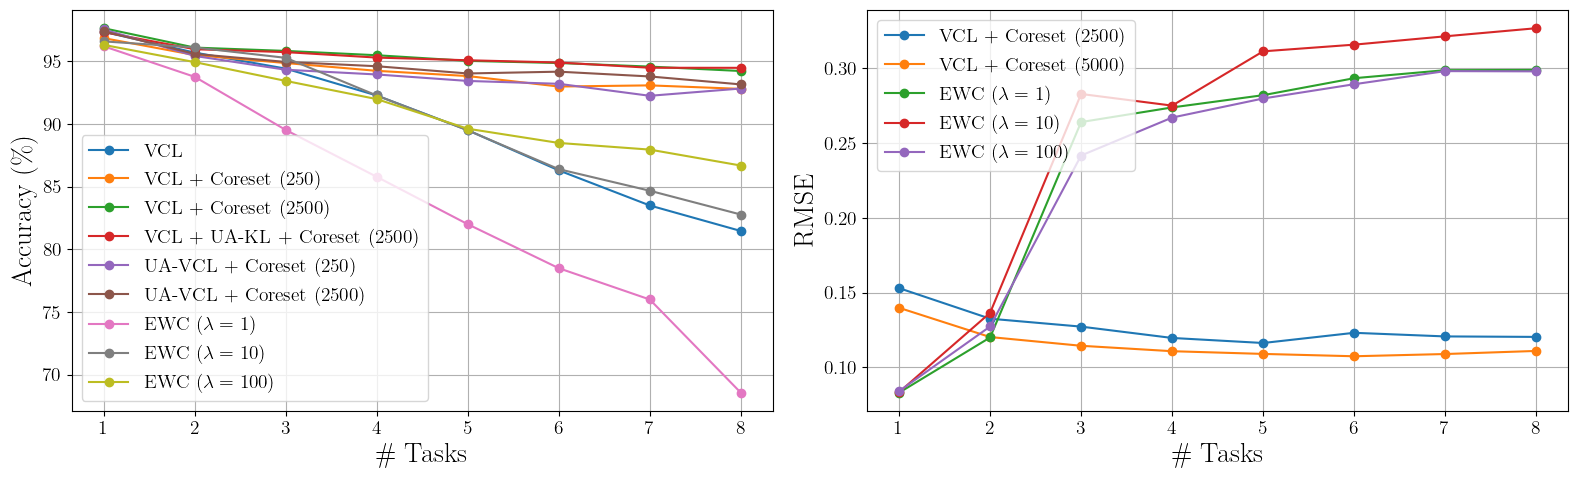

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot accuracy curves on ax1.
for key, value in classification_results.items():
    if any(substr in key for substr in ["CO", "alpha_0.5", "alpha_2", "coreset_5000"]):
        continue
    accuracies = value["accuracies"]
    tasks = np.arange(1, len(accuracies) + 1)
    label = generate_label(key)
    ax1.plot(tasks, accuracies, marker='o', label=label)
ax1.set_xlabel(r'\# Tasks', fontsize=20)
ax1.set_ylabel(r'Accuracy (\%)', fontsize=20)
ax1.set_xticks(np.arange(1, num_tasks + 1))
ax1.legend(loc='lower left')
ax1.grid(True)

# Plot RMSE curves on ax2.
for key, value in regression_results.items():
    rmse_values = value["RMSE"]
    tasks = np.arange(1, len(rmse_values) + 1)
    label = generate_label(key)
    ax2.plot(tasks, rmse_values, marker='o', label=label)
ax2.set_xlabel(r'\# Tasks', fontsize=20)
ax2.set_ylabel(r'RMSE', fontsize=20)
ax2.set_xticks(np.arange(1, num_tasks + 1))
ax2.legend(loc='upper left')
ax2.grid(True)

fig.tight_layout()
plt.savefig('combined_plot.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Visualization #2: Impact of Coreset Size

VCL_coreset_0_lambda_-1_alpha_1.0
VCL_coreset_250_lambda_-1_alpha_1.0
VCL_coreset_2500_lambda_-1_alpha_1.0
VCL_coreset_5000_lambda_-1_alpha_1.0
VCL-CO_coreset_250_lambda_-1_alpha_-1
VCL-CO_coreset_2500_lambda_-1_alpha_-1
VCL-CO_coreset_5000_lambda_-1_alpha_-1


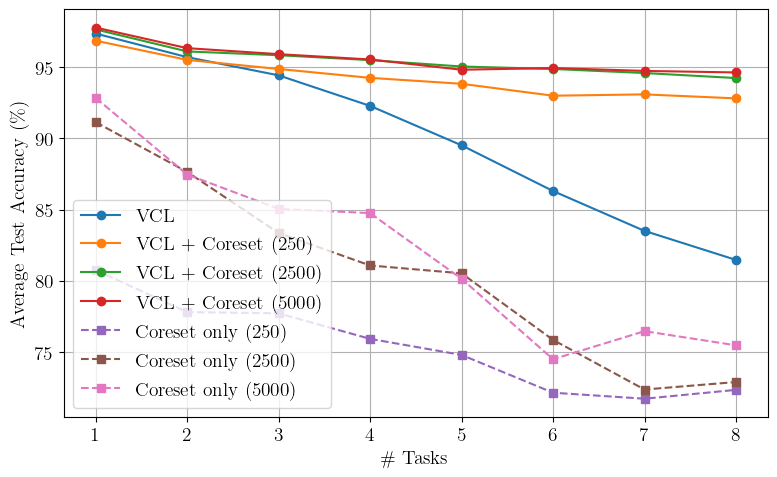

In [52]:
plt.figure(figsize=(8, 5))

# Iterate over each key in the results dictionary and plot the accuracies.
for key, value in classification_results.items():
    if "EWC" in key or "UA" in key or "WKL" in key:
      continue

    accuracies = value["accuracies"]
    tasks = np.arange(1, len(accuracies) + 1)
    label = generate_label(key)

    # Set different styles for curves pertaining to models only using coresets.
    if "CO" in key:
        marker = "s"
        linestyle = "--"
    else:
        marker = "o"
        linestyle = "-"

    plt.plot(tasks, accuracies, marker=marker, linestyle=linestyle, label=label)

plt.xlabel(r'\# Tasks')
plt.ylabel(r'Average Test Accuracy (\%)')
plt.xticks(np.arange(1, num_tasks + 1))
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('permuted_mnist_coreset_impact.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Visualization #3: Forgetting Curves

In [53]:
key = "UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0"
key_vcl = "VCL_coreset_2500_lambda_-1_alpha_1.0"

<ipython-input-54-6081fa62bda0>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


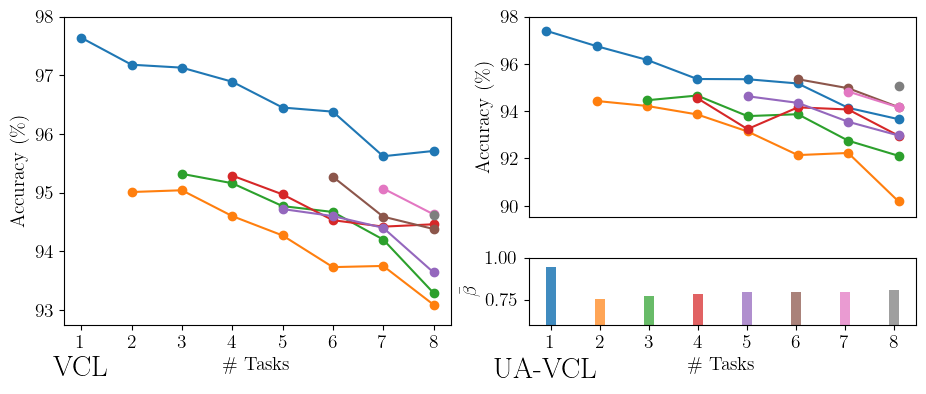

In [54]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[3,1], hspace=0.3)

# Left subplot: Normal VCL accuracy curves (spanning both rows of left column).
ax_left = fig.add_subplot(gs[:, 0])
ax_left.set_xlabel(r'\# Tasks')
ax_left.set_ylabel('Accuracy (\%)')
for t in range(1, num_tasks+1):
    task_key = f"task_{t}"
    y_vals = classification_results[key_vcl][task_key]
    if not y_vals:
        continue
    x_vals = np.arange(t, t + len(y_vals))
    ax_left.plot(x_vals, y_vals, marker='o', label=f"Task {t}")
ax_left.tick_params(axis='y')
ax_left.set_ylim(92.75, 98)
ax_left.set_xticks(np.arange(1, num_tasks+1))
ax_left.text(1, 92, "VCL", ha='center', va='center', fontsize=21)

# Right top subplot: UA-VCL accuracy curves.
ax_right_acc = fig.add_subplot(gs[0, 1])
ax_right_acc.set_ylabel('Accuracy (\%)')
for t in range(1, num_tasks+1):
    task_key = f"task_{t}"
    y_vals = classification_results[key][task_key]
    if not y_vals:
        continue
    x_vals = np.arange(t, t + len(y_vals))
    ax_right_acc.plot(x_vals, y_vals, marker='o', label=f"Task {t}")
ax_right_acc.tick_params(axis='y')
ax_right_acc.set_ylim(89.5, 98)
ax_right_acc.set_xticks(np.arange(1, num_tasks+1))
ax_right_acc.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_right_acc.text(1, 83, "UA-VCL", ha='center', va='center', fontsize=21)

# Right bottom subplot: beta bars.
ax_right_beta = fig.add_subplot(gs[1, 1])
ax_right_beta.set_xlabel(r'\# Tasks')
ax_right_beta.set_ylabel(r'$\bar{\beta}$')
beta_vals = classification_results[key]['mean_beta']

# Every epoch the average beta value gets added, therefore
# take the mean of them and skip the ones pertaining to calculating
# the predictive distribution.
epochs = global_params['epochs']
group_means = [np.mean(beta_vals[i:i+epochs]) for i in range(0, len(beta_vals), epochs * 2)]
x_beta = np.arange(1, len(group_means) + 1)
for x, beta_val in zip(x_beta, group_means):
    normalized_alpha = beta_val * 0.8 + 0.1
    ax_right_beta.bar(x, beta_val, alpha=normalized_alpha, width=0.2)
ax_right_beta.tick_params(axis='y')
ax_right_beta.set_ylim(0.6, 1)
ax_right_beta.set_xticks(np.arange(1, num_tasks+1))

# Create a shared legend for the task curves.
# handles, labels = ax_left.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=12)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('forgetting_curves.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Visualization #4: $\alpha$-impact


In [55]:
# Define the alpha values to check.
selected_alphas = ['alpha_0.5', 'alpha_1', 'alpha_2']
tasks = [1, 3, 5, 8]

# Iterate over the keys in classification_results dict.
for key, result in classification_results.items():
    # Check for the novel model and if the key contains one of
    # the selected alpha strings.
    if key[:6] == "UA-VCL" and any(alpha_str in key for alpha_str in selected_alphas):
        print(f"Key: {key}")
        accuracies = result["accuracies"]
        for t in tasks:
            print(f"Task {t} average accuracy: {accuracies[t - 1]}")
        print("")

Key: UA-VCL-WKL_coreset_250_lambda_-1_alpha_1.0
Task 1 average accuracy: 97.54
Task 3 average accuracy: 94.32666666666667
Task 5 average accuracy: 93.434
Task 8 average accuracy: 92.82875

Key: UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
Task 1 average accuracy: 97.4
Task 3 average accuracy: 94.95
Task 5 average accuracy: 94.03
Task 8 average accuracy: 93.1575

Key: UA-VCL-WKL_coreset_5000_lambda_-1_alpha_1.0
Task 1 average accuracy: 97.7
Task 3 average accuracy: 94.91
Task 5 average accuracy: 94.018
Task 8 average accuracy: 93.30875

Key: UA-VCL-WKL_coreset_2500_lambda_-1_alpha_0.5
Task 1 average accuracy: 97.75
Task 3 average accuracy: 94.57333333333334
Task 5 average accuracy: 94.508
Task 8 average accuracy: 93.67875

Key: UA-VCL-WKL_coreset_2500_lambda_-1_alpha_2
Task 1 average accuracy: 97.53
Task 3 average accuracy: 95.30333333333333
Task 5 average accuracy: 94.418
Task 8 average accuracy: 93.96375



### Visualization #5: Forgetting Curves Multi-Head

In [56]:
# Number of Split‑MNIST tasks.
num_tasks = 5

all_keys = list(classification_results_mh.keys())

# Pre‑compute mean curves for each key.
stats = {}
for key in all_keys:
    runs = list(classification_results_mh[key].keys())

    # Collect per‑task and overall metrics.
    task_acc_runs = {i: [] for i in range(1, num_tasks+1)}
    overall_runs  = []

    for run in runs:
        data = classification_results_mh[key][run]
        # Collect per‑task accuracy.
        for i in range(1, num_tasks+1):
            tk = f'task_{i}'
            if tk in data:
                task_acc_runs[i].append(data[tk])

        # Collect overall accuracy.
        overall_runs.append(data['accuracies'])

    # Now average them.
    mean_task_curves = {}
    for i in range(1, num_tasks+1):
        arr = np.stack(task_acc_runs[i], axis=0)
        mean_task_curves[i] = arr.mean(axis=0)

    overall_acc_stack  = np.stack(overall_runs, axis=0)
    mean_overall = overall_acc_stack.mean(axis=0)

    stats[key] = {
        'mean_task_curves': mean_task_curves,
        'mean_overall'    : mean_overall
    }

VCL_coreset_40_lambda_-1_alpha_1.0
VCL_coreset_0_lambda_-1_alpha_1.0
VCL-WKL_coreset_0_lambda_-1_alpha_1


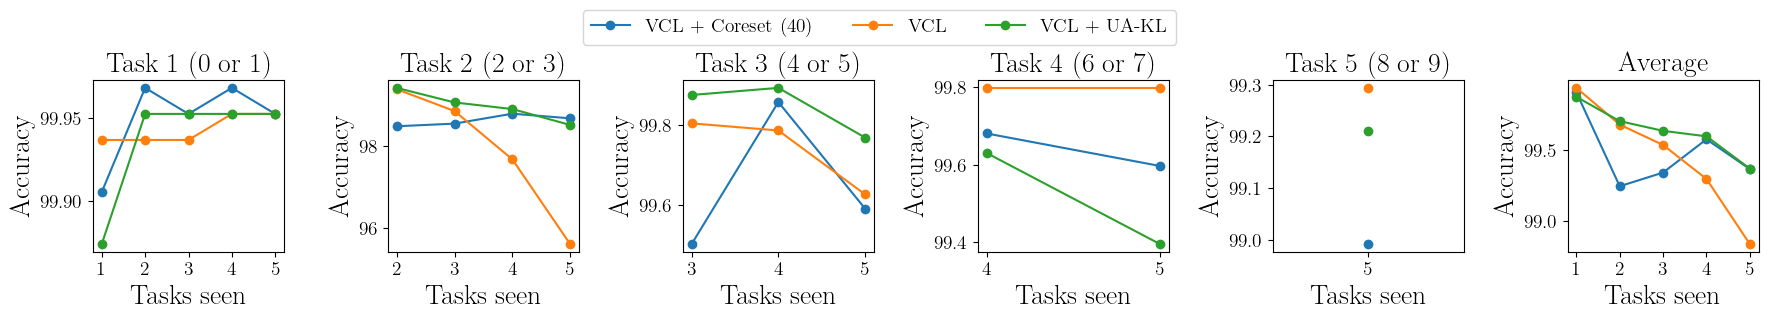

In [57]:
fig, axes = plt.subplots(1, num_tasks+1, figsize=((num_tasks+1)*3, 3))

for key, s in stats.items():
    mtc = s['mean_task_curves']
    mo  = s['mean_overall']
    for i in range(1, num_tasks+1):
        ax = axes[i-1]
        x = np.arange(i, num_tasks+1)
        y = mtc[i]
        ax.plot(x, y, marker='o')
        ax.set_title(f'Task {i} ({2*i-2} or {2*i-1})', fontsize=20)
        ax.set_xlabel('Tasks seen', fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=20)
        ax.set_xticks(x)

    ax = axes[-1]
    label = generate_label(key)
    ax.plot(np.arange(1, num_tasks+1), mo, marker='o', label=label)
    ax.set_title('Average', fontsize=20)
    ax.set_xlabel('Tasks seen', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=20)
    ax.set_xticks(np.arange(1, num_tasks+1))

fig.legend(
    loc='upper center',
    ncol=len(stats),
    bbox_to_anchor=(0.5, 1.10)
)
plt.tight_layout()
plt.savefig('forgetting_curves_mh.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Visualization #6: Generated Images from DGM

In [58]:
num_tasks = 10

def plot(rows, id):
    n = num_tasks
    fig, axes = plt.subplots(n, n, figsize=(n, n))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if j <= i:
                ax.imshow(rows[i][j], cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images_{id}.pdf", format="pdf", bbox_inches='tight')
    plt.show()

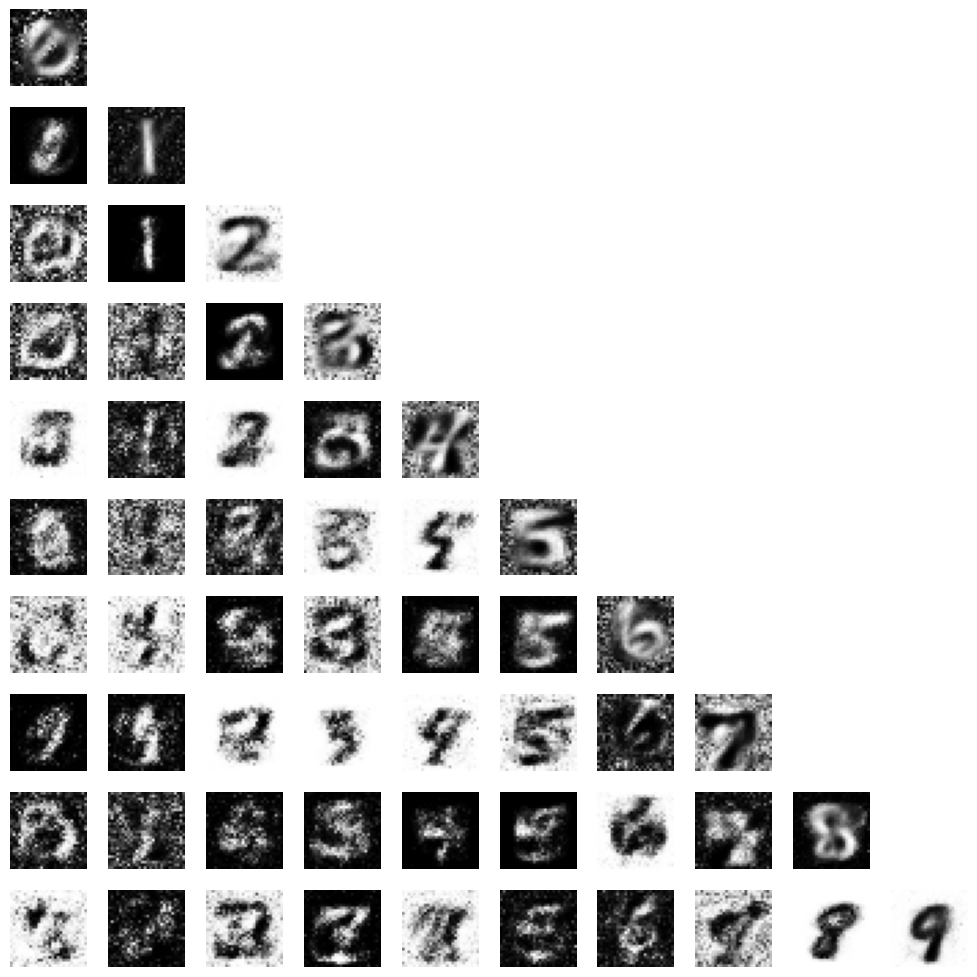

In [59]:
plot(generated_rows, "VCL")

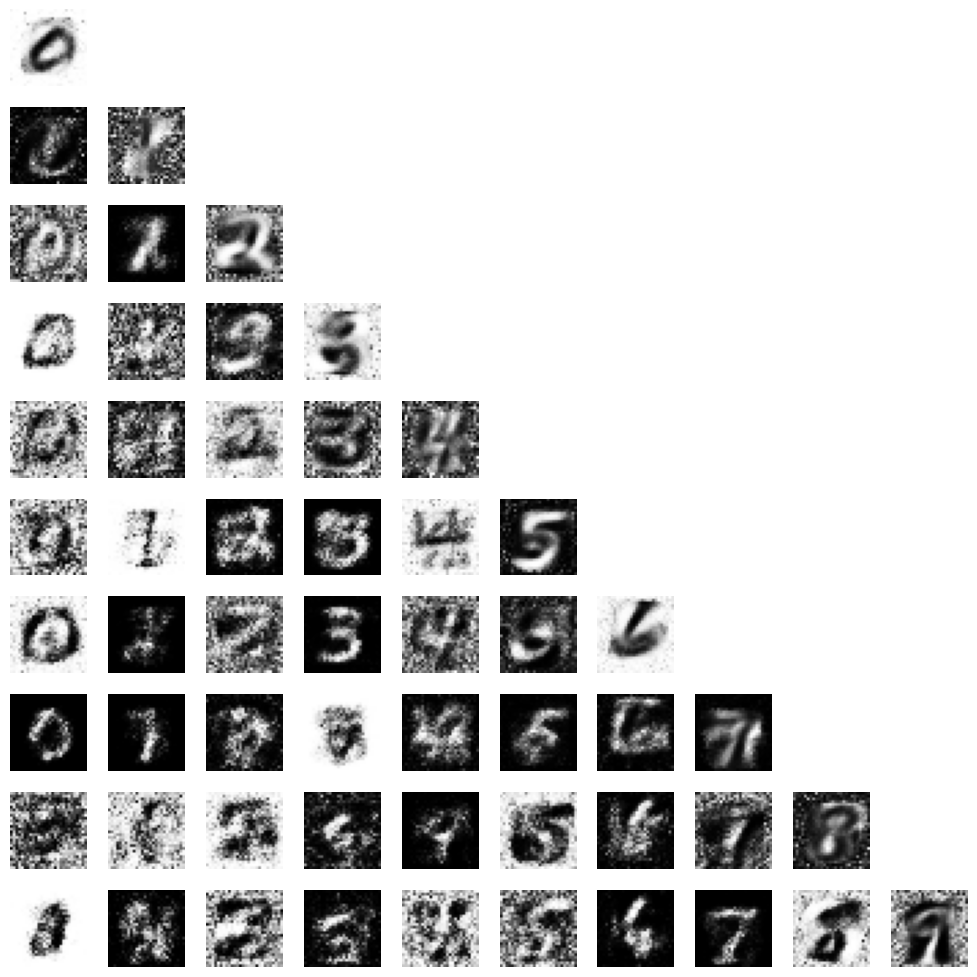

In [60]:
plot(generated_rows_naive, "Naive")